# Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [87]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers.convolutional import Conv2D
from keras.layers import Flatten,BatchNormalization
from keras.layers.merge import add
from keras.models import Sequential
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
import keras.metrics as metrics
tf.__version__

'2.3.0'

In [ ]:
!wget --no-check-certificate https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip
!unzip task5_collapse_mode.zip

--2020-10-26 23:06:07--  https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip
Resolving apps.peer.berkeley.edu (apps.peer.berkeley.edu)... 128.32.143.24, 2607:f140:0:f::24
Connecting to apps.peer.berkeley.edu (apps.peer.berkeley.edu)|128.32.143.24|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 232967101 (222M) [application/zip]
Saving to: ‘task5_collapse_mode.zip’

task5_collapse_mode 100%[===================>] 222.17M  39.5MB/s    in 6.0s    

2020-10-26 23:06:14 (36.7 MB/s) - ‘task5_collapse_mode.zip’ saved [232967101/232967101]

Archive:  task5_collapse_mode.zip
   creating: task5/
  inflating: task5/task5_X_test.npy  
  inflating: task5/task5_y_test.npy  
  inflating: task5/task5_X_train.npy  
  inflating: task5/task5_y_train.npy  
  inflating: task5/license.txt       
  inflating: task5/README.txt        


In [ ]:
!wget --no-check-certificate https://apps.peer.berkeley.edu/phichallenge/dataset/task1_scene_level.zip
!unzip task1_scene_level.zip

--2020-10-30 00:43:29--  https://apps.peer.berkeley.edu/phichallenge/dataset/task1_scene_level.zip
Resolving apps.peer.berkeley.edu (apps.peer.berkeley.edu)... 128.32.143.24, 2607:f140:0:f::24
Connecting to apps.peer.berkeley.edu (apps.peer.berkeley.edu)|128.32.143.24|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3551945848 (3.3G) [application/zip]
Saving to: ‘task1_scene_level.zip.1’

task1_scene_level.z 100%[===================>]   3.31G  19.2MB/s    in 3m 1s   

2020-10-30 00:46:31 (18.7 MB/s) - ‘task1_scene_level.zip.1’ saved [3551945848/3551945848]

Archive:  task1_scene_level.zip
replace task1/license.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Preprocessing

In [ ]:
base_file_path = 'task1/'
train_x_path = base_file_path + 'task1_X_train.npy'
test_x_path = base_file_path + 'task1_X_test.npy'
train_y_path = base_file_path + 'task1_y_train.npy'
test_y_path = base_file_path + 'task1_y_test.npy'


In [ ]:
raw_train_x = np.load(train_x_path)
np.random.seed(1)
np.random.shuffle(raw_train_x)

raw_train_y= np.load(train_y_path)
np.random.seed(1)
np.random.shuffle(raw_train_y)

In [ ]:
split = 0.8

n = raw_train_x.shape[0]
train_x = raw_train_x[0:int(n*split)]
val_x = raw_train_x[int(n*split):]
train_y = raw_train_y[0:int(n*split)]
val_y = raw_train_y[int(n*split):]

In [ ]:
input_shape = train_x.shape[1:]
num_class = train_y.shape[1]

In [ ]:
test_x = np.load(test_x_path)
test_y = np.load(test_y_path)
test_x.shape

(2997, 224, 224, 3)

In [ ]:
index = 601 
train_x_w[index] += 80
print(train_x_w[index])
plt.imshow(train_x_w[index].astype('uint8'))
print ("y = " + str(train_y_w[index]))
train_x_w[index] -= 80

# Data Augmentation

In [ ]:
from keras.preprocessing.image import *

In [ ]:
# Not 100% sure how this works but I think a data generator is the way to go
# Documentation: https://keras.io/api/preprocessing/image/ 
base_generator = ImageDataGenerator(
    data_format = 'channels_last'
)

data_augmentation_generator = ImageDataGenerator(
  data_format = 'channels_last',
  horizontal_flip = True, 
  rotation_range = 30, 
  validation_split = None
)

# Model

In [23]:
# Aggregation Statistics

train_performance = {}
val_performance = {}



In [94]:
def compile_and_fit(model, generator, patience=2, MAX_EPOCHS = 30, early_stop = False, val_split = 0.1, decay_step = 500,
                    batch_size = 64, initial_lr = 1e-3, lr_decay_rate = 0.9):

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate= initial_lr,
        decay_steps= decay_step,
        decay_rate= lr_decay_rate)at
  
    model.compile(loss=tf.losses.categorical_crossentropy,
                optimizer=tf.optimizers.Adam(learning_rate= lr_schedule),
                metrics=[metrics.Accuracy(), metrics.AUC()])
    
  
    if (early_stop == False):
    # history = model.fit(train_x, train_y, epochs=MAX_EPOCHS, batch_size = batch_size, )
        history = model.fit(generator.flow(train_x, train_y, batch_size = batch_size), epochs = MAX_EPOCHS, validation_data = (val_x, val_y))
    else:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')
        history = model.fit(train_x, train_y, epochs=MAX_EPOCHS, batch_size = batch_size, validation_split = val_split, callbacks=[early_stopping])

    return history

In [76]:
def evaluate_model(model, model_name, verbose = 1):
  train_performance[model_name] = model.evaluate(train_x, train_y, verbose= 1)
  val_performance[model_name] = model.evaluate(val_x, val_y, verbose= 1)

## Baseline

In [95]:
layers=[
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation=tf.nn.relu,input_shape=input_shape),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
        
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation=tf.nn.relu),
    
    tf.keras.layers.Dense(units=num_class, activation=tf.nn.softmax)
]

baseline=tf.keras.Sequential(layers)
baseline.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               25690240  
_________________________________________________________________
dense_30 (Dense)             (None, 3)                

In [101]:
history = compile_and_fit(baseline, base_generator, MAX_EPOCHS = 30)


Epoch 1/20
304/304 [==============================] - 18s 58ms/step - loss: 0.0941 - accuracy: 0.1017 - auc_3: 0.9963 - val_loss: 1.4184 - val_accuracy: 0.0584 - val_auc_3: 0.8911
Epoch 2/20
304/304 [==============================] - 15s 50ms/step - loss: 0.0711 - accuracy: 0.1097 - auc_3: 0.9976 - val_loss: 1.7800 - val_accuracy: 0.0876 - val_auc_3: 0.8803
Epoch 3/20
304/304 [==============================] - 15s 50ms/step - loss: 0.0964 - accuracy: 0.0971 - auc_3: 0.9962 - val_loss: 1.5944 - val_accuracy: 0.0583 - val_auc_3: 0.8854
Epoch 4/20
304/304 [==============================] - 15s 50ms/step - loss: 0.0562 - accuracy: 0.1203 - auc_3: 0.9984 - val_loss: 2.0498 - val_accuracy: 0.0609 - val_auc_3: 0.8635
Epoch 5/20
304/304 [==============================] - 15s 49ms/step - loss: 0.0542 - accuracy: 0.1436 - auc_3: 0.9986 - val_loss: 1.8652 - val_accuracy: 0.1104 - val_auc_3: 0.8816
Epoch 6/20
304/304 [==============================] - 15s 49ms/step - loss: 0.0415 - accuracy: 0.158

KeyboardInterrupt: ignored

In [99]:
evaluate_model(baseline, 'Baseline')

152/152 [==============================] - 2s 11ms/step - loss: 1.3836 - accuracy: 0.0659 - auc_2: 0.8915


## AlexNet

In [ ]:
# Ref: https://github.com/Keyird/DeepLearning-TensorFlow2/blob/master/4.%20AlexNet/AlexNet.py
Alex_layers=[
    # layer 1
    tf.keras.layers.Conv2D(48, kernel_size=11, strides=4, padding='same', activation='relu', input_shape=input_shape), 
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),  
    # layer 2
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'),  
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),  
    # layer 3
    tf.keras.layers.Conv2D(192, kernel_size=3, strides=1, padding='same', activation='relu'), 
    # layer 4
    tf.keras.layers.Conv2D(192, kernel_size=3, strides=1, padding='same', activation='relu'),
    # layer 5
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Flatten(), 
    # layer 6
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    # layer 7
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    # layer 8
    tf.keras.layers.Dense(num_class)
]

AlexNet=tf.keras.Sequential(Alex_layers)
AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 56, 56, 48)        17472     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       153728    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 192)       221376    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 192)       331968    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 128)      

In [ ]:
history = compile_and_fit(AlexNet)

train_performance['AlexNet'] = AlexNet.evaluate(train_x, train_y, verbose= 1)
val_performance['AlexNet'] = AlexNet.evaluate(val_x, val_y, verbose= 1)
performance['AlexNet'] = AlexNet.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 1s 50ms/step - loss: 1.0288 - accuracy: 0.1418 - val_loss: 1.1287 - val_accuracy: 0.1545
Epoch 2/30
16/16 [==============================] - 1s 42ms/step - loss: 1.2704 - accuracy: 0.1551 - val_loss: 1.5352 - val_accuracy: 0.1626
Epoch 3/30
16/16 [==============================] - 1s 42ms/step - loss: 0.9998 - accuracy: 0.1398 - val_loss: 1.1170 - val_accuracy: 0.1748
Epoch 4/30
16/16 [==============================] - 1s 42ms/step - loss: 1.0172 - accuracy: 0.1561 - val_loss: 1.0274 - val_accuracy: 0.1992
Epoch 5/30
16/16 [==============================] - 1s 43ms/step - loss: 1.0775 - accuracy: 0.1490 - val_loss: 1.5887 - val_accuracy: 0.1789
Epoch 6/30
16/16 [==============================] - 1s 42ms/step - loss: 1.7334 - accuracy: 0.2041 - val_loss: 1.1982 - val_accuracy: 0.2114
Epoch 7/30
16/16 [==============================] - 1s 43ms/step - loss: 1.1290 - accuracy: 0.2153 - val_loss: 1.0442 - val_accuracy: 0.2114
Epoch 8/30
16

## VGG

### VGG11

In [ ]:
# Ref: https://github.com/Keyird/DeepLearning-TensorFlow2/blob/master/5.%20VGG11/VGG11.py
VGG11_layers=[
    # layer 1
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape = input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    # layer 2
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    # layer 3
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    # layer 4
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    # layer 5
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    # layer 6
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    # layer 7
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    # layer 8
    tf.keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(), 
    # layer 9
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    # layer 10
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    # layer 11
    tf.keras.layers.Dense(num_class, activation='softmax')
]

VGG11=tf.keras.Sequential(VGG11_layers)
VGG11.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 56, 56, 256)       590080    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 256)      

In [ ]:
history = compile_and_fit(VGG11)

train_performance['VGG11'] = VGG11.evaluate(train_x, train_y, verbose= 1)
val_performance['VGG11'] = VGG11.evaluate(val_x, val_y, verbose= 1)
performance['VGG11'] = VGG11.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 6s 397ms/step - loss: 0.1085 - accuracy: 0.9633 - val_loss: 1.1917 - val_accuracy: 0.8008
Epoch 2/30
16/16 [==============================] - 6s 385ms/step - loss: 0.0399 - accuracy: 0.9847 - val_loss: 1.2009 - val_accuracy: 0.7683
Epoch 3/30
16/16 [==============================] - 6s 384ms/step - loss: 0.0336 - accuracy: 0.9888 - val_loss: 1.3640 - val_accuracy: 0.7724
Epoch 4/30
16/16 [==============================] - 6s 385ms/step - loss: 0.0778 - accuracy: 0.9816 - val_loss: 1.5804 - val_accuracy: 0.7195
Epoch 5/30
16/16 [==============================] - 6s 385ms/step - loss: 0.0628 - accuracy: 0.9827 - val_loss: 1.4561 - val_accuracy: 0.7154
Epoch 6/30
16/16 [==============================] - 6s 385ms/step - loss: 0.1000 - accuracy: 0.9755 - val_loss: 1.3159 - val_accuracy: 0.7317
Epoch 7/30
16/16 [==============================] - 6s 385ms/step - loss: 0.0446 - accuracy: 0.9867 - val_loss: 1.2564 - val_accuracy: 0.7358
Epoch 

### VGG16

In [ ]:
# Ref: https://keras.io/api/applications/vgg/
VGG16 = tf.keras.applications.VGG16(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling= max,
    classes= num_class,
    classifier_activation="softmax",
)

VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
history = compile_and_fit(VGG16)

train_performance['VGG16'] = VGG16.evaluate(train_x, train_y, verbose= 1)
val_performance['VGG16'] = VGG16.evaluate(val_x, val_y, verbose= 1)
performance['VGG16'] = VGG16.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 14s 898ms/step - loss: 1080.9412 - accuracy: 0.3653 - val_loss: 1.1003 - val_accuracy: 0.3293
Epoch 2/30
16/16 [==============================] - 13s 806ms/step - loss: 1.1446 - accuracy: 0.4000 - val_loss: 1.0875 - val_accuracy: 0.4187
Epoch 3/30
16/16 [==============================] - 13s 819ms/step - loss: 1.0858 - accuracy: 0.4306 - val_loss: 1.0825 - val_accuracy: 0.4146
Epoch 4/30
16/16 [==============================] - 13s 827ms/step - loss: 1.0786 - accuracy: 0.4316 - val_loss: 1.0825 - val_accuracy: 0.4146
Epoch 5/30
16/16 [==============================] - 13s 816ms/step - loss: 1.0757 - accuracy: 0.4316 - val_loss: 1.0907 - val_accuracy: 0.4146
Epoch 6/30
16/16 [==============================] - 13s 805ms/step - loss: 1.0777 - accuracy: 0.4316 - val_loss: 1.0808 - val_accuracy: 0.4146
Epoch 7/30
16/16 [==============================] - 13s 805ms/step - loss: 1.0847 - accuracy: 0.4316 - val_loss: 1.0815 - val_accuracy: 0.4

### VGG19

In [ ]:
# Ref: https://keras.io/api/applications/vgg/
VGG19 = tf.keras.applications.VGG19(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling= max,
    classes= num_class,
    classifier_activation="softmax",
)

VGG19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
history = compile_and_fit(VGG19)

train_performance['VGG19'] = VGG19.evaluate(train_x, train_y, verbose= 1)
val_performance['VGG19'] = VGG19.evaluate(val_x, val_y, verbose= 1)
performance['VGG19'] = VGG19.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 16s 984ms/step - loss: 7163.2656 - accuracy: 0.3602 - val_loss: 1.1120 - val_accuracy: 0.3252
Epoch 2/30
16/16 [==============================] - 15s 950ms/step - loss: 1.1383 - accuracy: 0.3908 - val_loss: 1.0788 - val_accuracy: 0.3496
Epoch 3/30
16/16 [==============================] - 15s 952ms/step - loss: 1.0814 - accuracy: 0.4255 - val_loss: 1.0767 - val_accuracy: 0.4146
Epoch 4/30
16/16 [==============================] - 16s 977ms/step - loss: 1.0884 - accuracy: 0.4316 - val_loss: 1.0889 - val_accuracy: 0.4146
Epoch 5/30
16/16 [==============================] - 15s 950ms/step - loss: 1.0898 - accuracy: 0.4316 - val_loss: 1.0864 - val_accuracy: 0.4146
Epoch 6/30
16/16 [==============================] - 15s 947ms/step - loss: 1.0820 - accuracy: 0.4316 - val_loss: 1.0816 - val_accuracy: 0.4146
Epoch 7/30
16/16 [==============================] - 15s 951ms/step - loss: 1.0770 - accuracy: 0.4316 - val_loss: 1.0936 - val_accuracy: 0.4

## GoogleNet

In [ ]:
# Ref: https://github.com/guaiguaibao/GoogLeNet_Tensorflow2.0/blob/master/tensorflow2.0/GoogLeNet/model.py
def GoogLeNet(im_height=224, im_width=224, class_num=num_class, aux_logits=False):
    input_image = layers.Input(shape= input_shape, dtype="float32")
    # (None, 224, 224, 3)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="SAME", activation="relu", name="conv2d_1")(input_image)
    # (None, 112, 112, 64)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_1")(x)
    # (None, 56, 56, 64)
    x = layers.Conv2D(64, kernel_size=1, activation="relu", name="conv2d_2")(x)
    # (None, 56, 56, 64)
    x = layers.Conv2D(192, kernel_size=3, padding="SAME", activation="relu", name="conv2d_3")(x)
    # (None, 56, 56, 192)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_2")(x)

    # (None, 28, 28, 192)
    x = Inception(64, 96, 128, 16, 32, 32, name="inception_3a")(x)
    # (None, 28, 28, 256)
    x = Inception(128, 128, 192, 32, 96, 64, name="inception_3b")(x)

    # (None, 28, 28, 480)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_3")(x)
    # (None, 14, 14, 480)
    x = Inception(192, 96, 208, 16, 48, 64, name="inception_4a")(x)
    if aux_logits:
        aux1 = InceptionAux(class_num, name="aux_1")(x)

    # (None, 14, 14, 512)
    x = Inception(160, 112, 224, 24, 64, 64, name="inception_4b")(x)
    # (None, 14, 14, 512)
    x = Inception(128, 128, 256, 24, 64, 64, name="inception_4c")(x)
    # (None, 14, 14, 512)
    x = Inception(112, 144, 288, 32, 64, 64, name="inception_4d")(x)
    if aux_logits:
        aux2 = InceptionAux(class_num, name="aux_2")(x)

    # (None, 14, 14, 528)
    x = Inception(256, 160, 320, 32, 128, 128, name="inception_4e")(x)
    # (None, 14, 14, 532)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding="SAME", name="maxpool_4")(x)

    # (None, 7, 7, 832)
    x = Inception(256, 160, 320, 32, 128, 128, name="inception_5a")(x)
    # (None, 7, 7, 832)
    x = Inception(384, 192, 384, 48, 128, 128, name="inception_5b")(x)
    # (None, 7, 7, 1024)
    x = layers.AvgPool2D(pool_size=7, strides=1, name="avgpool_1")(x)

    # (None, 1, 1, 1024)
    x = layers.Flatten(name="output_flatten")(x)
    # (None, 1024)
    x = layers.Dropout(rate=0.4, name="output_dropout")(x)
    x = layers.Dense(class_num, name="output_dense")(x)
    # (None, class_num)
    aux3 = layers.Softmax(name="aux_3")(x)

    if aux_logits:
        model = models.Model(inputs=input_image, outputs=[aux1, aux2, aux3])
    else:
        model = models.Model(inputs=input_image, outputs=aux3)
    return model


# Inception
class Inception(layers.Layer):
    def __init__(self, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj, **kwargs):
       
        super(Inception, self).__init__(**kwargs)
        self.branch1 = layers.Conv2D(ch1x1, kernel_size=1, activation="relu")

        self.branch2 = Sequential([
            layers.Conv2D(ch3x3red, kernel_size=1, activation="relu"),
            layers.Conv2D(ch3x3, kernel_size=3, padding="SAME", activation="relu")])      # output_size= input_size

        self.branch3 = Sequential([
            layers.Conv2D(ch5x5red, kernel_size=1, activation="relu"),
            layers.Conv2D(ch5x5, kernel_size=5, padding="SAME", activation="relu")])      # output_size= input_size

        self.branch4 = Sequential([
            layers.MaxPool2D(pool_size=3, strides=1, padding="SAME"),  # caution: default strides==pool_size
            layers.Conv2D(pool_proj, kernel_size=1, activation="relu")])                  # output_size= input_size

    def call(self, inputs, **kwargs):
        branch1 = self.branch1(inputs)
        branch2 = self.branch2(inputs)
        branch3 = self.branch3(inputs)
        branch4 = self.branch4(inputs)
        outputs = layers.concatenate([branch1, branch2, branch3, branch4])
        return outputs


class InceptionAux(layers.Layer):
    def __init__(self, num_classes, **kwargs):
        super(InceptionAux, self).__init__(**kwargs)
        self.averagePool = layers.AvgPool2D(pool_size=5, strides=3)
        self.conv = layers.Conv2D(128, kernel_size=1, activation="relu")

        self.fc1 = layers.Dense(1024, activation="relu")
        self.fc2 = layers.Dense(num_classes)
        self.softmax = layers.Softmax()

    def call(self, inputs, **kwargs):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(inputs)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = layers.Flatten()(x)
        x = layers.Dropout(rate=0.5)(x)  
        # N x 2048
        x = self.fc1(x)
        x = layers.Dropout(rate=0.5)(x)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        x = self.softmax(x)

        return x

GoogleNet_model = GoogLeNet(class_num = num_class)
GoogleNet_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        4160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 192)       110784    
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 28, 28, 192)       0         
_________________________________________________________________
inception_3a (Inception)     (None, 28, 28, 256)      

In [ ]:
history = compile_and_fit(GoogleNet_model)

train_performance['GoogleNet_model'] = GoogleNet_model.evaluate(train_x, train_y, verbose= 1)
val_performance['GoogleNet_model'] = GoogleNet_model.evaluate(val_x, val_y, verbose= 1)
performance['GoogleNet_model'] = GoogleNet_model.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30
16/16 [==============================] - 4s 249ms/step - loss: 1.0514 - accuracy: 0.5796 - val_loss: 0.8439 - val_accuracy: 0.6382
Epoch 2/30
16/16 [==============================] - 3s 210ms/step - loss: 0.7843 - accuracy: 0.6347 - val_loss: 0.8312 - val_accuracy: 0.6260
Epoch 3/30
16/16 [==============================] - 3s 212ms/step - loss: 0.7243 - accuracy: 0.6520 - val_loss: 0.7814 - val_accuracy: 0.6545
Epoch 4/30
16/16 [==============================] - 3s 213ms/step - loss: 0.6915 - accuracy: 0.6816 - val_loss: 0.7177 - val_accuracy: 0.6667
Epoch 5/30
16/16 [==============================] - 3s 215ms/step - loss: 0.6381 - accuracy: 0.7245 - val_loss: 0.7233 - val_accuracy: 0.6748
Epoch 6/30
16/16 [==============================] - 3s 216ms/step - loss: 0.6188 - accuracy: 0.7163 - val_loss: 0.6997 - val_accuracy: 0.7033
Epoch 7/30
16/16 [==============================] - 3s 217ms/step - loss: 0.5923 - accuracy: 0.7439 - val_loss: 0.8003 - val_accuracy: 0.6748
Epoch 

## ResNet

### Resnet 50

In [ ]:
# Ref: https://keras.io/api/applications/resnet/
ResNet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling= max,
    classes= num_class,
    classifier_activation="softmax",
)

ResNet50.summary()

In [82]:
# history = compile_and_fit(ResNet50, base_generator)

# train_performance['ResNet50'] = ResNet50.evaluate(train_x, train_y, verbose= 1)
# val_performance['ResNet50'] = ResNet50.evaluate(val_x, val_y, verbose= 1)
# # performance['ResNet50'] = ResNet50.evaluate(test_X, test_y, verbose= 1)

history = compile_and_fit(ResNet50, data_augmentation_generator, MAX_EPOCHS=10)

# train_performance['ResNet50WithAug'] = ResNet50.evaluate(train_x, train_y, verbose= 1)
# val_performance['ResNet50WithAug'] = ResNet50.evaluate(val_x, val_y, verbose= 1)
# performance['ResNet50WithAug'] = ResNet50.evaluate(test_X, test_y, verbose= 1)

Epoch 1/10
304/304 [==============================] - 186s 610ms/step - loss: 0.4884 - accuracy: 0.7988
Epoch 2/10
304/304 [==============================] - 183s 604ms/step - loss: 0.4369 - accuracy: 0.8190
Epoch 3/10
304/304 [==============================] - 185s 608ms/step - loss: 0.4219 - accuracy: 0.8264
Epoch 4/10
304/304 [==============================] - 185s 609ms/step - loss: 0.4173 - accuracy: 0.8256
Epoch 5/10
304/304 [==============================] - 188s 620ms/step - loss: 0.3976 - accuracy: 0.8366
Epoch 6/10
304/304 [==============================] - 183s 603ms/step - loss: 0.3855 - accuracy: 0.8419
Epoch 7/10
304/304 [==============================] - 182s 599ms/step - loss: 0.3747 - accuracy: 0.8471
Epoch 8/10
304/304 [==============================] - 183s 603ms/step - loss: 0.3675 - accuracy: 0.8487
Epoch 9/10
304/304 [==============================] - 184s 604ms/step - loss: 0.3535 - accuracy: 0.8574
Epoch 10/10
304/304 [==============================] - 192s 631m

In [83]:
evaluate_model(ResNet50, "ResNet50")

152/152 [==============================] - 5s 36ms/step - loss: 0.3743 - accuracy: 0.8470


### Resnet 152

In [ ]:
# Ref: https://keras.io/api/applications/resnet/
ResNet152 = tf.keras.applications.ResNet152(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_shape,
    pooling= max,
    classes= num_class,
    classifier_activation="softmax",
)

ResNet152.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_37[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
# out of meomery 
history = compile_and_fit(ResNet152)

train_performance['ResNet152'] = ResNet152.evaluate(train_x, train_y, verbose= 1)
val_performance['ResNet152'] = ResNet152.evaluate(val_x, val_y, verbose= 1)
performance['ResNet152'] = ResNet152.evaluate(test_X, test_y, verbose= 1)

Epoch 1/30


ResourceExhaustedError: ignored

## Transfer Learning

In [73]:
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top = False,
    input_shape=input_shape
)


x = tf.keras.layers.GlobalAveragePooling2D()(base_model.layers[-1].output)
outputs = tf.keras.layers.Dense(num_class, activation = tf.keras.activations.softmax)(x)

tl_model = tf.keras.Model(inputs = base_model.inputs, outputs = outputs)
print(len(tl_model.layers))
for i in range(0, 150):
  tl_model.layers[i].trainable = False

tl_model.summary(line_length= 200)

177
Model: "functional_44"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_35 (InputLayer)                                             [(None, 224, 224, 3)]                       0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)                                         (None, 230, 230, 3)                         0                       input_35[0][0]                     

In [74]:
history = compile_and_fit(tl_model, base_generator, MAX_EPOCHS=10)


Epoch 1/10
304/304 [==============================] - 26s 84ms/step - loss: 0.2319 - accuracy: 0.9157
Epoch 2/10
304/304 [==============================] - 26s 85ms/step - loss: 0.1342 - accuracy: 0.9507
Epoch 3/10
304/304 [==============================] - 26s 84ms/step - loss: 0.0804 - accuracy: 0.9715
Epoch 4/10
304/304 [==============================] - 26s 84ms/step - loss: 0.0453 - accuracy: 0.9860
Epoch 5/10
304/304 [==============================] - 26s 84ms/step - loss: 0.0331 - accuracy: 0.9903
Epoch 6/10
304/304 [==============================] - 26s 85ms/step - loss: 0.0202 - accuracy: 0.9943
Epoch 7/10
304/304 [==============================] - 26s 84ms/step - loss: 0.0128 - accuracy: 0.9969
Epoch 8/10
304/304 [==============================] - 26s 84ms/step - loss: 0.0080 - accuracy: 0.9983
Epoch 9/10
304/304 [==============================] - 26s 85ms/step - loss: 0.0051 - accuracy: 0.9989
Epoch 10/10
304/304 [==============================] - 26s 85ms/step - loss: 0.008

In [79]:
evaluate_model(tl_model, "Transfer Learning")

152/152 [==============================] - 6s 37ms/step - loss: 0.3289 - accuracy: 0.9272


In [85]:
history = compile_and_fit(tl_model, data_augmentation_generator, MAX_EPOCHS=10)
evaluate_model(tl_model, "TL + AUG")  

Epoch 1/10
304/304 [==============================] - 195s 642ms/step - loss: 0.1294 - accuracy: 0.9528
Epoch 2/10
304/304 [==============================] - 193s 634ms/step - loss: 0.0913 - accuracy: 0.9671
Epoch 3/10
304/304 [==============================] - 192s 632ms/step - loss: 0.0707 - accuracy: 0.9752
Epoch 4/10
304/304 [==============================] - 187s 616ms/step - loss: 0.0589 - accuracy: 0.9791
Epoch 5/10
304/304 [==============================] - 187s 614ms/step - loss: 0.0494 - accuracy: 0.9827
Epoch 6/10
304/304 [==============================] - 183s 601ms/step - loss: 0.0418 - accuracy: 0.9853
Epoch 7/10
304/304 [==============================] - 183s 601ms/step - loss: 0.0311 - accuracy: 0.9893
Epoch 8/10
304/304 [==============================] - 184s 605ms/step - loss: 0.0294 - accuracy: 0.9903
Epoch 9/10
304/304 [==============================] - 184s 604ms/step - loss: 0.0269 - accuracy: 0.9910
Epoch 10/10
152/152 [==============================] - 6s 36ms/s

## Performance

In [135]:
x = np.arange(len(train_performance))
width = 0.2


def generate_metric_plt(metric_name):
  metric_index = ResNet50.metrics_names.index(metric_name)
  train_acc = [v[metric_index] for _, v in sorted(train_performance.items(), key = lambda x: x[0])]
  val_acc = [v[metric_index] for _, v in sorted(val_performance.items(), key = lambda x: x[0])]
  # test_acc = [v[metric_index] for v in performance.values()]
  print(val_performance)
  print(train_performance)
  plt.figure(figsize=(12, 8))
  plt.bar(x - 0.23, train_acc, width, label='Training')
  plt.bar(x, val_acc, width, label='Validation')
  plt.xticks(ticks=x, labels=sorted(train_performance.keys()),
            rotation=45)
  plt.ylabel(metric_name)
  _ = plt.legend()
  return plt

{'Baseline': [1.3835515975952148, 0.06588509678840637, 0.8914709687232971], 'ResNet50': [0.37425974011421204, 0.8469765782356262], 'Transfer Learning': [0.3288501501083374, 0.9271904826164246], 'TL + AUG': [0.2867913246154785, 0.933772087097168]}
{'Baseline': [0.06956971436738968, 0.09346771240234375, 0.9981369376182556], 'ResNet50': [0.3193565011024475, 0.8716511726379395], 'Transfer Learning': [0.0074171950109303, 0.9978917241096497], 'TL + AUG': [0.006147296633571386, 0.9983030557632446]}


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

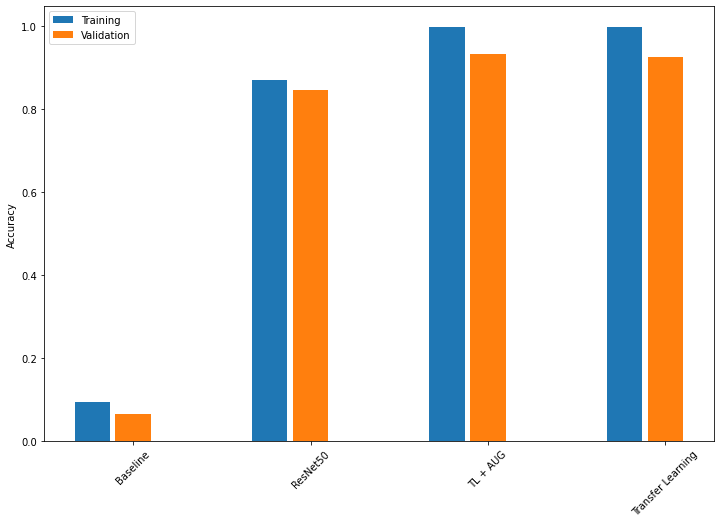

In [136]:
generate_metric_plt('accuracy')

In [104]:
generate_metric_plt('auc_2')

ValueError: ignored